In [1]:
from sbdataextraction import sbdataextraction as sbd

import time 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms.traversal.depth_first_search import dfs_edges
from networkx.algorithms.dag import dag_longest_path

# Analyzing pass sequences using clustering and expected goals

## 1. Getting the data

In [2]:
season_11_21 = sbd.fetch_matches_for_season(11, 21)

Fetching matches for season_id 21 of competition_id 11...
[==================================] 100%

In [154]:
season_11_21

{69239: <sbdataextraction.sbdataextraction.Game at 0x106415d50>,
 69221: <sbdataextraction.sbdataextraction.Game at 0xa137b7490>,
 69218: <sbdataextraction.sbdataextraction.Game at 0xa1510b750>,
 69210: <sbdataextraction.sbdataextraction.Game at 0xa15d16b90>,
 69219: <sbdataextraction.sbdataextraction.Game at 0xa16c89750>,
 69220: <sbdataextraction.sbdataextraction.Game at 0xa17a18090>,
 69214: <sbdataextraction.sbdataextraction.Game at 0xa17e54ad0>,
 69227: <sbdataextraction.sbdataextraction.Game at 0xa19503310>,
 69229: <sbdataextraction.sbdataextraction.Game at 0xa19daafd0>,
 69233: <sbdataextraction.sbdataextraction.Game at 0xa1a9edf10>,
 69213: <sbdataextraction.sbdataextraction.Game at 0xa1b6737d0>,
 69224: <sbdataextraction.sbdataextraction.Game at 0xa1bde20d0>,
 69226: <sbdataextraction.sbdataextraction.Game at 0xa1de9bb10>,
 69237: <sbdataextraction.sbdataextraction.Game at 0xa1de9b490>,
 69238: <sbdataextraction.sbdataextraction.Game at 0xa1f6249d0>,
 69242: <sbdataextraction

In [220]:
season_11_21[69239].get_events_for_game().loc[season_11_21[69239].get_events_for_game()["related events"].isna()]

time event name  team_id  \
event id                                                                 
6e6550db-54b4-452b-9e54-66aa888100b2  00:00:26.133       pass      213   
d9cb9f69-0c3c-41e2-8beb-3711733d9ec7  00:13:55.197       pass      213   
2d176c21-b44c-4ba1-9171-700f3dfa2d60  00:15:19.458       pass      217   
df9f26e0-67f5-46ba-8e95-88c015d156b4  00:19:14.754       pass      217   
d4b8825a-b80d-4b97-9771-82f3c955dc25  00:36:47.811       pass      213   
d3e964ec-1aee-49bf-a4e6-16e3b711c0fb  00:44:07.527       pass      213   
9d8cb0b9-4b38-43d7-bca9-d2302c2f223a  00:45:16.166       pass      213   
64196884-5409-4b8c-b49a-bd4863709c05  00:45:50.846       pass      217   
c59edcef-0750-4b0d-ab19-9796941cf060  00:20:56.280       pass      213   
860aac5f-0bd7-4efb-9557-6ef743c2e468  00:36:46.573       pass      213   

                                      team_name  player_id  \
event id                                                     
6e6550db-54b4-452b-9e54-66aa888100b2    Sevilla      26018   
d9cb9f69-0c3c-41e2-8beb-3711733d9ec7    Sevilla      26683   
2d176c21-b44c-4ba1-9171-700f3dfa2d60  Barcelona       5203   
df9f26e0-67f5-46ba-8e95-88c015d156b4  Barcelona      25946   
d4b8825a-b80d-4b97-9771-82f3c955dc25    Sevilla      22102   
d3e964ec-1aee-49bf-a4e6-16e3b711c0fb    Sevilla      26015   
9d8cb0b9-4b38-43d7-bca9-d2302c2f223a    Sevilla       6821   
64196884-5409-4b8c-b49a-bd4863709c05  Barcelona      20176   
c59edcef-0750-4b0d-ab19-9796941cf060    Sevilla      25960   
860aac5f-0bd7-4efb-9557-6ef743c2e468    Sevilla       6821   

                                                   player_name  \
event id                                                         
6e6550db-54b4-452b-9e54-66aa888100b2             Julien Escudé   
d9cb9f69-0c3c-41e2-8beb-3711733d9ec7            Abdoulay Konko   
2d176c21-b44c-4ba1-9171-700f3dfa2d60  Sergio Busquets i Burgos   
df9f26e0-67f5-46ba-8e95-88c015d156b4      Andrés Palop Cervera   
d4b8825a-b80d-4b97-9771-82f3c955dc25     Adriano Correia Claro   
d3e964ec-1aee-49bf-a4e6-16e3b711c0fb   Renato Dirnei Florencio   
9d8cb0b9-4b38-43d7-bca9-d2302c2f223a      Jesús Navas González   
64196884-5409-4b8c-b49a-bd4863709c05     Víctor Valdés Arribas   
c59edcef-0750-4b0d-ab19-9796941cf060    Frédéric Oumar Kanouté   
860aac5f-0bd7-4efb-9557-6ef743c2e468      Jesús Navas González   

                                      x start location  y start location  \
event id                                                                   
6e6550db-54b4-452b-9e54-66aa888100b2              54.4              40.9   
d9cb9f69-0c3c-41e2-8beb-3711733d9ec7              39.8              76.0   
2d176c21-b44c-4ba1-9171-700f3dfa2d60              65.8               2.2   
df9f26e0-67f5-46ba-8e95-88c015d156b4               8.2              29.2   
d4b8825a-b80d-4b97-9771-82f3c955dc25              23.6               1.0   
d3e964ec-1aee-49bf-a4e6-16e3b711c0fb              76.0              17.6   
9d8cb0b9-4b38-43d7-bca9-d2302c2f223a              97.0              79.3   
64196884-5409-4b8c-b49a-bd4863709c05              11.8              42.6   
c59edcef-0750-4b0d-ab19-9796941cf060              85.6              31.5   
860aac5f-0bd7-4efb-9557-6ef743c2e468              55.0              69.5   

                                      x end location  y end location  \
event id                                                               
6e6550db-54b4-452b-9e54-66aa888100b2            82.5             3.4   
d9cb9f69-0c3c-41e2-8beb-3711733d9ec7            41.5            80.4   
2d176c21-b44c-4ba1-9171-700f3dfa2d60           106.5            24.7   
df9f26e0-67f5-46ba-8e95-88c015d156b4            78.0            16.8   
d4b8825a-b80d-4b97-9771-82f3c955dc25            56.4            15.0   
d3e964ec-1aee-49bf-a4e6-16e3b711c0fb           104.3            56.3   
9d8cb0b9-4b38-43d7-bca9-d2302c2f223a           113.8            39.5   
64196884-5409-4b8c-b49a-bd4863709c05            90.3      

### 1.1 Make events dataframe for all events in the season

In [3]:
season_event_df = season_11_21[69239].get_events_for_game()
for game_id, game in season_11_21.items():
    event_df = game.get_events_for_game()
    if game_id != 69239:
        season_event_df = season_event_df.append(event_df)

season_event_df["time"] = pd.to_datetime(season_event_df["time"])
without_date = season_event_df['time'].apply(lambda d : d.time())
season_event_df['time'] = without_date

### 1.2 Make graph of related events

In [239]:
game_event_graphs = {}
for game_id, game in season_11_21.items():
    events_graph = nx.Graph()
    events_graph.add_nodes_from(game.event_df.index)
    
    for index, row in game.event_df.iterrows():
        if row["related events"] is not None:
            events_graph.add_edges_from([(index, x) for x in row["related events"] 
                                         if (x in game.event_df.index) # and 
                                         #    season_event_df.loc[index]["time"] < season_event_df.loc[x]["time"])
                                        ])
        
    game_event_graphs[game_id] = events_graph

In [244]:
season_sequences = []
for game_id, event_graph in game_event_graphs.items():
    game_sequences = []
    for components in list(nx.connected_components(event_graph)):
        components_order_df = season_event_df.loc[list(components)]["time"]
        components_sorted = list(components_order_df.sort_values().index)
        game_sequences.append(components_sorted)
    season_sequences.append(game_sequences)

In [246]:
season_sequences[0][0]

['8a7a2c38-f0fe-4707-ba9c-4f7c85bd9247',
 '36dedfe3-9f1b-4b30-a916-e499c497499c',
 'e05ff950-d19c-476b-9304-5c1aafdb60ff',
 'a5625b97-1c9d-4262-9179-0ac2ba69867f',
 '9b842801-f850-415a-9183-4943df9d470e',
 '22d232f0-d118-46d0-9708-ed6be24717a8',
 'af327f67-0dd3-4464-a505-e0c7bde4d29d',
 '05a5fca4-bb97-46c1-abe2-72ab462160f7',
 'd177b948-efeb-4ca4-b11b-34a689b67c42']

In [247]:
season_event_df.loc[season_sequences[0][0]]

time     event name  team_id  \
event id                                                                        
8a7a2c38-f0fe-4707-ba9c-4f7c85bd9247  00:00:01.057000           pass      213   
36dedfe3-9f1b-4b30-a916-e499c497499c  00:00:01.504000          carry      213   
e05ff950-d19c-476b-9304-5c1aafdb60ff  00:00:01.504000  ball receipt*      213   
a5625b97-1c9d-4262-9179-0ac2ba69867f  00:00:02.506000           pass      213   
9b842801-f850-415a-9183-4943df9d470e  00:00:03.286000  ball receipt*      213   
22d232f0-d118-46d0-9708-ed6be24717a8  00:00:03.286000          carry      213   
af327f67-0dd3-4464-a505-e0c7bde4d29d  00:00:07.029000           pass      213   
05a5fca4-bb97-46c1-abe2-72ab462160f7  00:00:08.212000          carry      213   
d177b948-efeb-4ca4-b11b-34a689b67c42  00:00:08.212000  ball receipt*      213   

                                     team_name  player_id  \
event id                                                    
8a7a2c38-f0fe-4707-ba9c-4f7c85bd9247   Sevilla      26015   
36dedfe3-9f1b-4b30-a916-e499c497499c   Sevilla      25943   
e05ff950-d19c-476b-9304-5c1aafdb60ff   Sevilla      25943   
a5625b97-1c9d-4262-9179-0ac2ba69867f   Sevilla      25943   
9b842801-f850-415a-9183-4943df9d470e   Sevilla       6821   
22d232f0-d118-46d0-9708-ed6be24717a8   Sevilla       6821   
af327f67-0dd3-4464-a505-e0c7bde4d29d   Sevilla       6821   
05a5fca4-bb97-46c1-abe2-72ab462160f7   Sevilla      26683   
d177b948-efeb-4ca4-b11b-34a689b67c42   Sevilla      26683   

                                                  player_name  \
event id                                                        
8a7a2c38-f0fe-4707-ba9c-4f7c85bd9247  Renato Dirnei Florencio   
36dedfe3-9f1b-4b30-a916-e499c497499c    Luís Fabiano Clemente   
e05ff950-d19c-476b-9304-5c1aafdb60ff    Luís Fabiano Clemente   
a5625b97-1c9d-4262-9179-0ac2ba69867f    Luís Fabiano Clemente   
9b842801-f850-415a-9183-4943df9d470e     Jesús Navas González   
22d232f0-d118-46d0-9708-ed6be24717a8     Jesús Navas González   
af327f67-0dd3-4464-a505-e0c7bde4d29d     Jesús Navas González   
05a5fca4-bb97-46c1-abe2-72ab462160f7           Abdoulay Konko   
d177b948-efeb-4ca4-b11b-34a689b67c42           Abdoulay Konko   

                                      x start location  y start location  \
event id                                                                   
8a7a2c38-f0fe-4707-ba9c-4f7c85bd9247              61.0              41.0   
36dedfe3-9f1b-4b30-a916-e499c497499c              62.1              40.1   
e05ff950-d19c-476b-9304-5c1aafdb60ff              62.1              40.1   
a5625b97-1c9d-4262-9179-0ac2ba69867f              62.8              46.1   
9b842801-f850-415a-9183-4943df9d470e              69.9              68.0   
22d232f0-d118-46d0-9708-ed6be24717a8              69.9              68.0   
af327f67-0dd3-4464-a505-e0c7bde4d29d              71.6              75.1   
05a5fca4-bb97-46c1-abe2-72ab462160f7              92.5              79.9   
d177b948-efeb-4ca4-b11b-34a689b67c42              92.5              79.9   

                                      x end location  y end location  \
event id                                                               
8a7a2c38-f0fe-4707-ba9c-4f7c85bd9247            62.1            40.1   
36dedfe3-9f1b-4b30-a916-e499c497499c            62.8            46.1   
e05ff950-d19c-476b-9304-5c1aafdb60ff            -1.0            -1.0   
a5625b97-1c9d-4262-9179-0ac2ba69867f            69.9            68.0   
9b842801-f850-415a-9183-4943df9d470e            -1.0            -1.0   
22d232f0-d118-46d0-9708-ed6be24717a8            71.6            75.1   
af327f67-0dd3-4464-a505-e0c7bde4d29d            92.5            79.9   
05a5fca4-bb97-46c1-abe2-72ab462160f7            97.0            79.0   
d177b948-efeb-4ca4-b11b-34a689b67c42            -1.0            -1.0   

                                      statsbomb xg  \
event id                                             
8a7a2c38-f0fe-4707-ba9c-4f7c85b

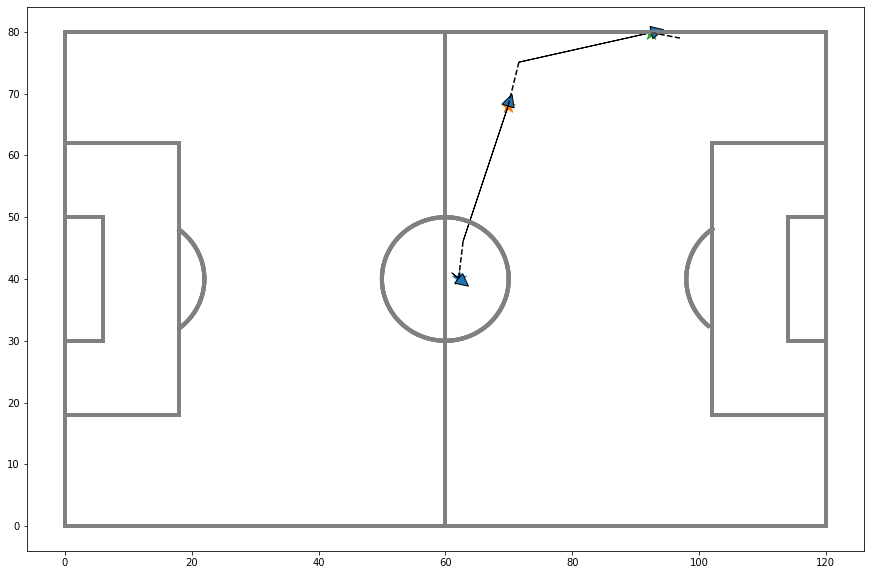

In [248]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
for event in season_sequences[0][0]:
    sbd.draw_pitch(axis=ax, rotate=True)
    sbd.plot_event(season_11_21[69239], event, axis=ax)

## 2. Pass clustering

In [249]:
import math
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [250]:
season_pass_df = season_event_df[season_event_df["event name"] == "pass"].iloc[:, 6:10]
x1 = season_pass_df["x start location"]
x2 = season_pass_df["x end location"]
y1 = season_pass_df["y start location"]
y2 = season_pass_df["y end location"]
season_pass_df["length"] = np.sqrt((x2-x1)**2 + (y2-y1)**2)
season_pass_df["angle"] = list(map(lambda x, y: math.atan2(x, y), x2-x1, y2-y1))
season_pass_df

x start location  y start location  \
event id                                                                   
8a7a2c38-f0fe-4707-ba9c-4f7c85bd9247              61.0              41.0   
a5625b97-1c9d-4262-9179-0ac2ba69867f              62.8              46.1   
af327f67-0dd3-4464-a505-e0c7bde4d29d              71.6              75.1   
09e078a9-cfa2-4a03-8d4d-a33529d95819             105.5              80.0   
5b7a45a1-3cc3-4cf1-ad60-69bef51ec545              76.5              60.2   
...                                                ...               ...   
6a0f145b-d417-484c-ae38-37054e4703ef              62.9              76.2   
9075d00f-ad29-4dad-b010-1a9c12742a1a              80.8              65.5   
83b1e530-2286-492c-971d-3759c6ec85d5               9.4              48.9   
2a073984-8d34-4915-a495-0a016877580f              44.4              24.1   
7a94c6f2-3291-4c7b-a51b-dc4f529a99f0              13.8              26.2   

                                      x end location  y end location  \
event id                                                               
8a7a2c38-f0fe-4707-ba9c-4f7c85bd9247            62.1            40.1   
a5625b97-1c9d-4262-9179-0ac2ba69867f            69.9            68.0   
af327f67-0dd3-4464-a505-e0c7bde4d29d            92.5            79.9   
09e078a9-cfa2-4a03-8d4d-a33529d95819            80.2            69.4   
5b7a45a1-3cc3-4cf1-ad60-69bef51ec545            54.0            40.9   
...                                              ...             ...   
6a0f145b-d417-484c-ae38-37054e4703ef            80.8            65.5   
9075d00f-ad29-4dad-b010-1a9c12742a1a           115.2            47.9   
83b1e530-2286-492c-971d-3759c6ec85d5            80.0            57.5   
2a073984-8d34-4915-a495-0a016877580f           106.4            51.0   
7a94c6f2-3291-4c7b-a51b-dc4f529a99f0           109.0            55.0   

                                         length     angle  
event id                                                   
8a7a2c38-f0fe-4707-ba9c-4f7c85bd9247   1.421267  2.256526  
a5625b97-1c9d-4262-9179-0ac2ba69867f  23.022163  0.313509  
af327f67-0dd3-4464-a505-e0c7bde4d29d  21.444113  1.345046  
09e078a9-cfa2-4a03-8d4d-a33529d95819  27.430822 -1.967550  
5b7a45a1-3cc3-4cf1-ad60-69bef51ec545  29.643549 -2.279788  
...                                         ...       ...  
6a0f145b-d417-484c-ae38-37054e4703ef  20.854256  2.109571  
9075d00f-ad29-4dad-b010-1a9c12742a1a  38.640911  2.043703  
83b1e530-2286-492c-971d-3759c6ec85d5  71.121867  1.449580  
2a073984-8d34-4915-a495-0a016877580f  67.584096  1.161436  
7a94c6f2-3291-4c7b-a51b-dc4f529a99f0  99.460947  1.277028  

[35445 rows x 6 columns]

In [251]:
cols = ["x start location", "y start location", "length", "angle"]
ss = StandardScaler()
season_pass_df_transformed = ss.fit_transform(season_pass_df[cols])
season_pass_df_transformed

array([[ 0.07680454,  0.02384468, -1.37677736,  1.00425552],
       [ 0.14629899,  0.24426414,  0.1189719 , -0.08715424],
       [ 0.48604963,  1.49762972,  0.00970019,  0.49226927],
       ...,
       [-1.91536967,  0.36527875,  3.44962522,  0.55098718],
       [-0.56408871, -0.70656492,  3.20465302,  0.38913384],
       [-1.74549435, -0.61580396,  5.41195851,  0.45406308]])

In [544]:
n_cluster = 120
kmeans = KMeans(n_clusters=n_cluster, n_init=10)
kmeans.fit_predict(season_pass_df_transformed);

In [545]:
season_pass_df["cluster"] = kmeans.labels_

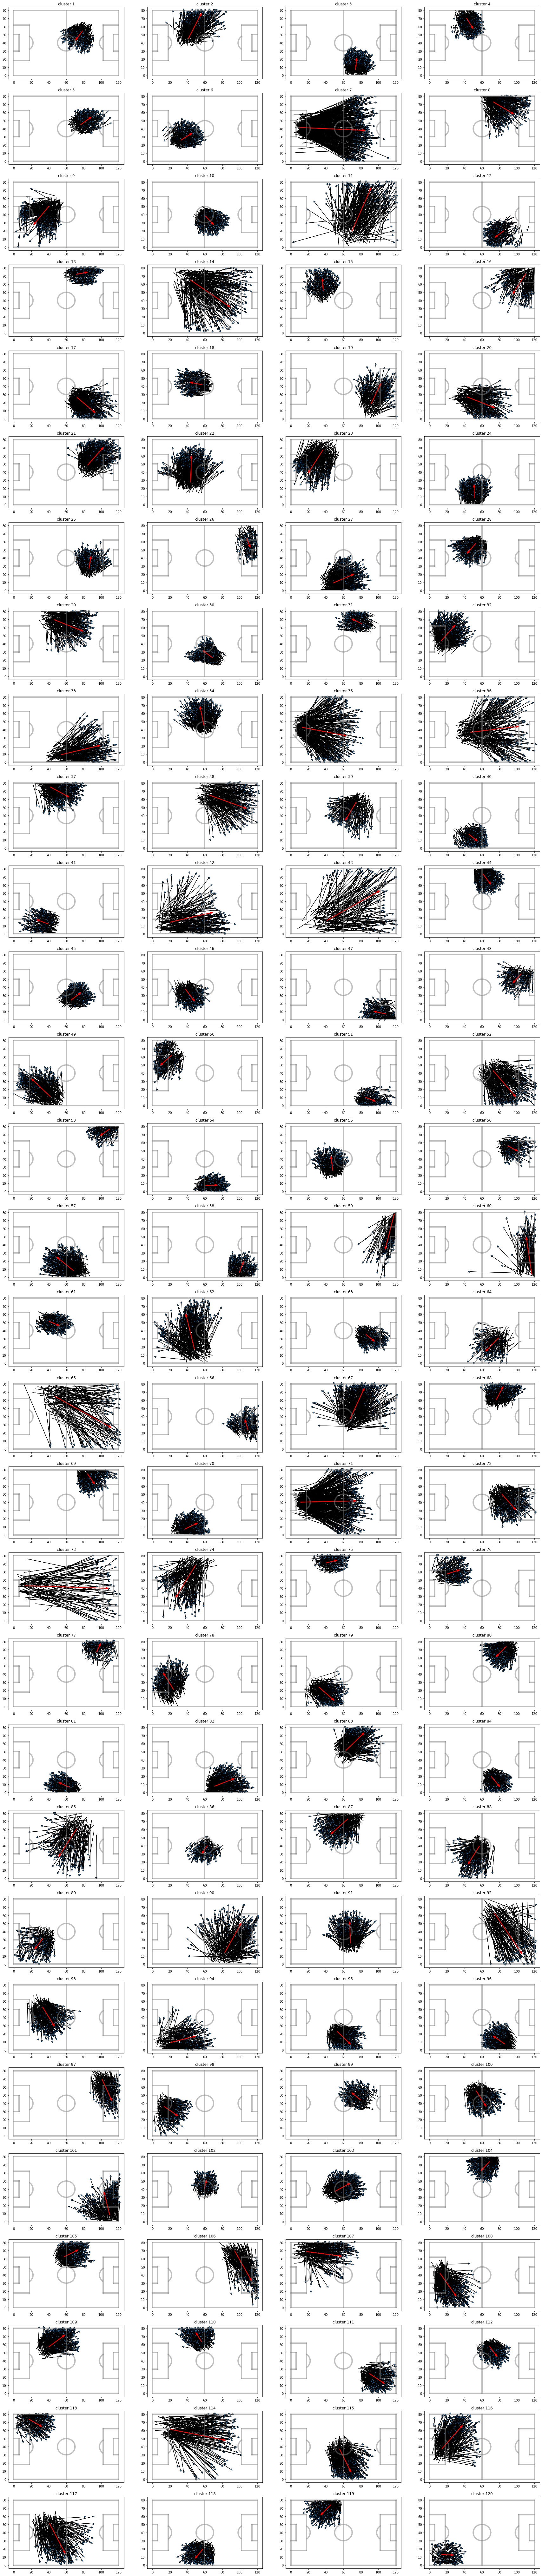

In [546]:
axis_cols = 4
axis_rows = int(np.ceil(n_cluster / axis_cols))
fig, axs = plt.subplots(axis_rows, axis_cols, figsize=(30, 0.66*(30/axis_cols)*axis_rows))
ax = axs.reshape(-1)
for i, axi in enumerate(ax):
    sbd.draw_pitch(axis=axi, rotate=True)
    axi.set_title(f"cluster {i+1}", size=12)
for game_id, game in season_11_21.items():
    event_df_game = game.event_df
    pass_df_game = event_df_game[event_df_game["event name"] == "pass"]
    for index, row, in pass_df_game.iterrows():
        axis_num = int(season_pass_df.loc[index]["cluster"])
        sbd.plot_event(game, index, axis=ax[axis_num])

# plot cluster centers
for i, pass_coords in enumerate(ss.inverse_transform(kmeans.cluster_centers_)):
    ax[i].arrow(pass_coords[0], pass_coords[1], pass_coords[2]*np.sin(pass_coords[3]), pass_coords[2]*np.cos(pass_coords[3]),
                head_width=2, linewidth=2, color="red")

## 3. Rating passes with xg

In [547]:
all_sequences_xg = []
for game_sequences in season_sequences:
    for sequence in game_sequences:
        xg = 0
        for event_id in sequence:
            if season_event_df.loc[event_id]["event name"] == "shot":
                xg = season_event_df.loc[event_id]["statsbomb xg"]
        all_sequences_xg.append(xg)

In [548]:
event_xg_dict = {}
for game_sequences in season_sequences:
    for i, sequence in enumerate(game_sequences):
        for event_id in sequence:
            event_xg_dict[event_id] = all_sequences_xg[i]
            
event_xg_column = []
for index, row in season_pass_df.iterrows():
    xg = 0
    if index in event_xg_dict.keys():
        xg = event_xg_dict[index]
    event_xg_column.append(xg)

In [549]:
season_pass_df["event xg"] = event_xg_column

In [550]:
season_pass_df.groupby("cluster").mean().sort_values("event xg", ascending=False).head(30)

x start location  y start location  x end location  y end location  \
cluster                                                                       
110             90.002098         24.135315      102.919580       14.741259   
119             13.771711         13.103947       22.796053       12.228947   
98              79.471181         44.085764       72.583681       50.437153   
4               76.411420         44.932099       85.420988       51.966975   
52             109.436199         76.661991      101.893665       71.440271   
50              85.266225         10.132119       92.911589        7.100662   
37              65.734021         64.851031      100.271649       51.454124   
15             110.021910         72.596067       98.853933       52.600562   
7               73.032364         72.882909       91.237091       61.183273   
57              99.560241          6.061044      102.731325       15.423695   
51              72.687603         43.026033       94.321074       15.629752   
100            109.567692          8.478462      105.109615       31.093846   
21              43.841327         27.611735       44.762755       54.460459   
73              49.294904         68.100637       30.790446       34.085987   
63              78.883523         31.009091       68.034091       18.628409   
84              71.815436         60.746980       56.161745       32.497315   
1               41.256379         45.462551       54.066667       71.138683   
32              54.094845          9.214433       93.549485       19.453093   
0               78.551290         54.613548       72.794839       46.214839   
93              20.814480          9.144796       44.605882       15.098190   
47             104.614286         56.180612       98.653061       48.311224   
35              46.817021         36.758511       90.286170       42.257979   
95              86.271825          7.212302       76.168651       14.700992   
96             100.973778         69.338222      110.179111       46.807556   
36              41.741195         75.092767       58.713522       65.346541   
45              38.074926         37.079351       45.779646       26.017404   
8               40.062963         50.114141       27.230976       32.721212   
90              68.070482         25.826807       67.183133       46.872892   
67              76.187097         60.348848       82.664286       72.863594   
34              12.950178         42.869751       52.996441       34.688968   

            length     angle  event xg  
cluster                                 
110      17.975939  2.191220  0.021818  
119      10.959507  1.629033  0.021033  
98       10.537986 -0.835358  0.019698  
4        12.500120  0.914733  0.018833  
52       10.488129 -2.216344  0.018645  
50        9.308391  1.976481  0.018466  
37       41.886781  1.940912  0.017824  
15       25.710632 -2.597510  0.017495  
7        24.633454  2.136927  0.016449  
57       11.190836  0.335702  0.016222  
51       38.219375  2.465770  0.016071  
100      26.037388 -0.228588  0.015510  
21       29.548095  0.021384  0.015160  
73       42.640350 -2.624244  0.014937  
63       19.049167 -2.415010  0.014791  
84       36.882291 -2.603857  0.014435  
1        31.298376  0.447125  0.014310  
32       43.252176  1.320853  0.014307  
0        10.965241 -2.529853  0.014053  
93       27.112893  1.304296  0.013930  
47       11.434501 -2.439582  0.013647  
35       52.782393  1.438667  0.013594  
95       13.826636 -0.944982  0.013574  
96       25.568523  2.739836  0.013440  
36       21.950527  2.095985  0.013419  
45       14.623750  2.516504  0.013347  
8        25.684682 -2.486387  0.013146  
90       23.441152 -0.037260  0.013090  
67       15.420607  0.454748  0.012931  
34       48.348592  1.774901  0.012929

## 4. RNN

In [551]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, LSTM, Dropout
from keras.preprocessing.sequence import pad_sequences

**IMPORTANT:** Cluster indices in pass_sequence list will be 1 greater than cluster indices given by Kmeans.

In [552]:
pass_sequences = []
for game_sequence in season_sequences:
    for sequence in game_sequence:
        pass_sequence = []
        for event in sequence:
            if event in season_pass_df.index:
                pass_sequence.append(1+season_pass_df.loc[event]["cluster"])
        pass_sequences.append(pass_sequence)

**Map xg to sequences and remove sequences with no passes:**

In [553]:
pass_seq_xg_df = pd.DataFrame({"pass seq" : pass_sequences, "xg" : all_sequences_xg})
seq_len_mask = pass_seq_xg_df["pass seq"].apply(lambda x: len(x) > 0)
pass_seq_xg_df = pass_seq_xg_df.loc[seq_len_mask]
pass_seq_xg_df

pass seq   xg
0        [10.0, 34.0, 8.0]  0.0
1       [16.0, 85.0, 36.0]  0.0
2             [90.0, 32.0]  0.0
3      [61.0, 109.0, 91.0]  0.0
4             [72.0, 66.0]  0.0
...                    ...  ...
13899        [120.0, 42.0]  0.0
13900   [105.0, 8.0, 38.0]  0.0
13901                [7.0]  0.0
13902               [43.0]  0.0
13903               [73.0]  0.0

[12518 rows x 2 columns]

**Pad sequences with 0s**

In [554]:
padded_sequence = np.reshape(pad_sequences(pass_seq_xg_df["pass seq"].to_list()), 
                            (pad_sequences(pass_seq_xg_df["pass seq"].to_list()).shape[0], pad_sequences(pass_seq_xg_df["pass seq"].to_list()).shape[1]))

In [560]:
n_last_passes = 3
padded_sequence = padded_sequence[:, -n_last_passes:]

**Split into training, validation and test sets:**

In [561]:
train_prop = 0.75
val_prop = 0.15
n_sequences = padded_sequence.shape[0]

shuffled_indices = np.random.choice(n_sequences, n_sequences, replace=False)
train_ind = shuffled_indices[0:int(n_sequences*train_prop)]
val_ind = shuffled_indices[int(n_sequences*train_prop):int(n_sequences*train_prop)+int(n_sequences*val_prop)]
test_ind = shuffled_indices[int(n_sequences*train_prop)+int(n_sequences*val_prop):]

X_train = padded_sequence[train_ind]
X_val = padded_sequence[val_ind]
X_test = padded_sequence[test_ind]

In [562]:
y_train = pass_seq_xg_df["xg"].to_numpy()[train_ind]
y_val = pass_seq_xg_df["xg"].to_numpy()[val_ind]
y_test = pass_seq_xg_df["xg"].to_numpy()[test_ind]

### 4.1 Build LSTM model

In [574]:
model = Sequential()
model.add(Embedding(121, 300))
model.add(LSTM(300, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mean_squared_error'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 300)         36300     
_________________________________________________________________
lstm_22 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dropout_22 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 301       
Total params: 757,801
Trainable params: 757,801
Non-trainable params: 0
_________________________________________________________________


In [575]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=1)
model.fit(X_train, y_train, epochs=5, verbose=1, batch_size=50, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/5
188/188 [==============================] - 3s 16ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 2/5
188/188 [==============================] - 3s 15ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0028 - val_mean_squared_error: 0.0028


In [576]:
sequence_xg_pred = model.predict(X_test)

In [577]:
sequence_score_df = pd.DataFrame({"seq": [list(x) for x in X_test], "score" : sequence_xg_pred.flatten()}).sort_values("score", ascending=False).head(100)
sequence_score_df

seq     score
1118   [25, 115, 90]  0.016733
728     [79, 27, 90]  0.016244
488      [112, 5, 5]  0.015037
988    [32, 115, 19]  0.013931
1218   [23, 115, 27]  0.013638
...              ...       ...
308     [96, 30, 64]  0.002618
1084  [118, 24, 118]  0.002598
296    [115, 82, 64]  0.002505
615      [2, 38, 48]  0.002476
17       [6, 91, 56]  0.002475

[100 rows x 2 columns]

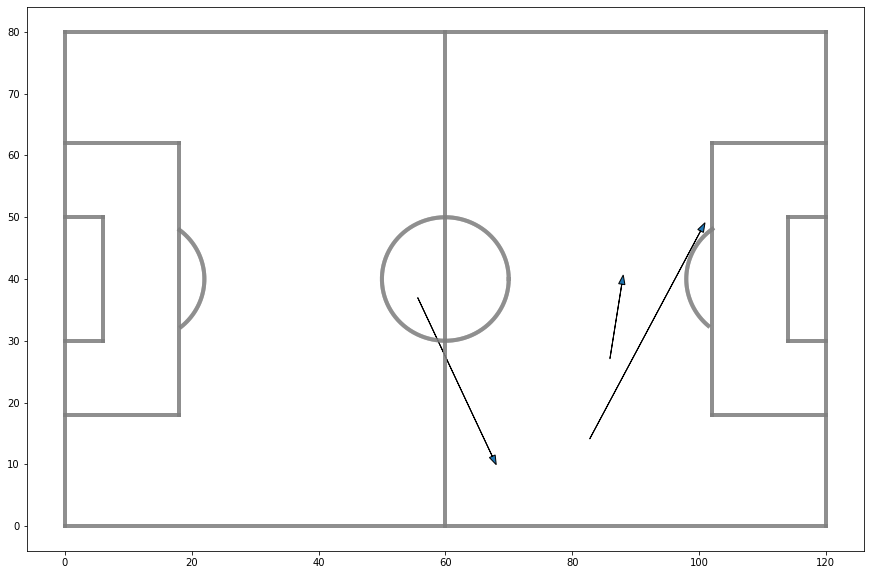

In [579]:
pass_num = 1
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
for index, row in sequence_score_df.iloc[pass_num-1:pass_num].iterrows():
    for pass_ in row["seq"]:
        pass_coords = ss.inverse_transform(kmeans.cluster_centers_[pass_-1])
        sbd.draw_pitch(axis=ax, rotate=True)
        ax.arrow(pass_coords[0], pass_coords[1], pass_coords[2]*np.sin(pass_coords[3]), pass_coords[2]*np.cos(pass_coords[3]),
                 head_width=1)